In [74]:
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
from tld import tridiagonal_method

In [75]:
Lx = np.pi 
Ly = np.pi
T = 2

n = 50
m = 50
K = 50

In [76]:
a = 1
b = 1
mu = 2

In [77]:
ax = a
ay = b
bx = 0
by = 0
c = 0

def f(x, y, t):
    return np.sin(x) * np.sin(y) * (mu * np.cos(mu * t) + (a + b) * np.sin(mu * t))

In [78]:
alpha_0_y = 0
beta_0_y = 1

alpha_Lx_y = 1
beta_Lx_y = 0

alpha_x_0 = 0
beta_x_0 = 1

alpha_x_Ly = 1
beta_x_Ly = 0

In [79]:
def gamma_0_y(y, t):
    return 0

def gamma_lx_y(y, t):
    return -np.sin(y) * np.sin(mu * t)

def gamma_x_0(x, t):
    return 0

def gamma_x_ly(x, t):
    return -np.sin(x) * np.sin(mu * t)

def u0(x, y):
    return 0

In [80]:
def analytical(x, y, t):
    return np.sin(x) * np.sin(y) * np.sin(mu * t)

In [81]:
hx = Lx / (n - 1)
hy = Ly / (m - 1)
tau = T / (K - 1)

hx2 = hx ** 2
hy2 = hy ** 2
tau2 = tau ** 2

In [82]:
t = [k * tau for k in range(K - 1)]
t.append(T)
t = np.array(t)

x = [i * hx for i in range(n - 1)]
x.append(Lx)
x = np.array(x)

y = [i * hy for i in range(m - 1)]
y.append(Ly)
y = np.array(y)

In [83]:
f_ijk = np.ndarray((n, m, K))
for i in range(n):
    for j in range(m):
        for k in range(K):
            f_ijk[i][j][k] = f(x[i], y[j], t[k])

grid_u0 = np.ndarray((n, m, 1))
for i in range(n):
    for j in range(m):
        grid_u0[i][j][0] = u0(x[i], y[j])

grid_0_y = np.ndarray((1, m, K))
grid_lx_y = np.ndarray((1, m, K))

for k in range(K):
    for j in range(m):
        grid_0_y[0][j][k] = gamma_0_y(y[j], t[k])
        grid_lx_y[0][j][k] = gamma_lx_y(y[j], t[k])

grid_x_0 = np.ndarray((n, 1, K))
grid_x_ly = np.ndarray((n, 1, K))
for k in range(K):
    for i in range(n):
        grid_x_0[i][0][k] = gamma_x_0(x[i], t[k])
        grid_x_ly[i][0][k]  = gamma_x_ly(x[i], t[k])


In [84]:
# with open("in.txt", "w") as file_in:
#     write_arr(file_in, [nx, ny, K, psi])
#     write_arr(file_in, [lx, ly, T, hx, hy, tau])
#     write_arr(file_in, [ax, ay, bx, by, c])
#     write_tensor3(file_in, f_ijk)
#     write_tensor3(file_in, grid_u0)

#     write_arr(
#         file_in,
#         [
#             alpha_0_y,
#             alpha_x_0,
#             beta_0_y,
#             beta_x_0,
#             alpha_lx_y,
#             alpha_x_ly,
#             beta_lx_y,
#             beta_x_ly,
#         ],
#     )
#     write_tensor3(file_in, grid_0_y)
#     write_tensor3(file_in, grid_x_0)
#     write_tensor3(file_in, grid_lx_y)
#     write_tensor3(file_in, grid_x_ly)

In [85]:
bound_coefs_0_y = [0, 0]
bound_coefs_0_y[0] = beta_0_y - alpha_0_y / hx
bound_coefs_0_y[1] = alpha_0_y / hx

In [86]:
bound_coefs_lx_y = [0, 0]
bound_coefs_lx_y[0] = -alpha_Lx_y / hx
bound_coefs_lx_y[1] = beta_Lx_y + alpha_Lx_y / hx

In [87]:
bound_coefs_x_0 = [0, 0]
bound_coefs_x_0[0] = beta_x_0 - alpha_x_0 / hy
bound_coefs_x_0[1] = alpha_x_0 / hy

In [88]:
bound_coefs_x_ly = [0, 0]
bound_coefs_x_ly[0] = -alpha_x_Ly / hy
bound_coefs_x_ly[1] = beta_x_Ly + alpha_x_Ly / hy

prepare coeffs 1

In [89]:
coefs_x_1 = [0] * 6
coefs_x_1[0] = ax / hx2 - bx / (2 * hx)
coefs_x_1[1] = -2 * ax / hx2 - 2 / tau + c
coefs_x_1[2] = ax / hx2 + bx / (2 * hx)
coefs_x_1[3] = -ay / hy2 + by / (2 * hy)
coefs_x_1[4] = -2 / tau + 2 * ay / hy2
coefs_x_1[5] = -ay / hy2 - by / (2 * hy)

coefs_y_1 = [0] * 6
coefs_y_1[0] = ay / hy2 - by / (2 * hy)
coefs_y_1[1] = -2 * ay / hy2 - 2 / tau + c
coefs_y_1[2] = ay / hy2 + by / (2 * hy)
coefs_y_1[3] = -ax / hx2 + bx / (2 * hx)
coefs_y_1[4] = 2 * ax / hx2 - 2 / tau
coefs_y_1[5] = -ax / hx2 - bx / (2 * hx)

In [90]:
def get_boundary_x(u, k):
    for i in range(n): 
        rhs_x_0 = (grid_x_0[i][0][k] + grid_x_0[i][0][k + 1]) / 2 - bound_coefs_x_0[1] * u[i][1][0]
        lhs_x_0 = bound_coefs_x_0[0]
        u[i][0][0] = rhs_x_0 / lhs_x_0
        rhs_x_ly = (grid_x_ly[i][0][k] + grid_x_ly[i][0][k + 1]) / 2 - \
            bound_coefs_x_ly[0] * u[i][m - 2][0]
        lhs_x_ly = bound_coefs_x_ly[1]
        u[i][m - 1][0] = rhs_x_ly / lhs_x_ly

    return u

In [91]:
def get_boundary_y(u, k):
    for j in range(m): 
        rhs_0_y = grid_0_y[0][j][k + 1] - bound_coefs_0_y[1] * u[1][j][0]
        lhs_0_y = bound_coefs_0_y[0]
        u[0][j][0] = rhs_0_y / lhs_0_y

        rhs_lx_y = grid_lx_y[0][j][k + 1] - bound_coefs_lx_y[0] * u[n - 2][j][0]
        lhs_lx_y = bound_coefs_lx_y[1]
        u[n - 1][j][0] = rhs_lx_y / lhs_lx_y
    return u

In [92]:
def alternating_direction():
    def calculate_x(u_prev, u, k):
        A = np.zeros(n)
        B = np.zeros(n)
        C = np.zeros(n)
        D = np.zeros(n)

        for j in range(1, m - 1):
            for i in range(1, n - 1):
                A[i] = coefs_x_1[0]
                B[i] = coefs_x_1[1]
                C[i] = coefs_x_1[2]
                D[i] = coefs_x_1[3] * u_prev[i][j - 1][0] + \
                             coefs_x_1[4] * u_prev[i][j][0] + \
                             coefs_x_1[5] * u_prev[i][j + 1][0] - \
                             (f_ijk[i][j][k] + f_ijk[i][j][k + 1]) / 2 

            B[0] = bound_coefs_0_y[0]
            C[0] = bound_coefs_0_y[1]
            D[0] = (grid_0_y[0][j][k] + grid_0_y[0][j][k + 1]) / 2
            A[n - 1] = bound_coefs_lx_y[0]
            B[n - 1] = bound_coefs_lx_y[1]
            D[n - 1] = (grid_lx_y[0][j][k] + grid_lx_y[0][j][k + 1]) / 2
            
            res = tridiagonal_method(A, B, C, D)
            for i in range(n):
                u[i][j][0] = res[i]

        u = get_boundary_x(u, k)

        return u

    def calculate_y(u_prev, u, k):
        A = np.zeros(m)
        B = np.zeros(m)
        C = np.zeros(m)
        D = np.zeros(m)

        for i in range(1, n - 1):
            for j in range(1, m - 1):
                A[j] = coefs_y_1[0]
                B[j] = coefs_y_1[1]
                C[j] = coefs_y_1[2]
                D[j] = coefs_y_1[3] * u_prev[i - 1][j][0] + \
                             coefs_y_1[4] * u_prev[i][j][0] + \
                             coefs_y_1[5] * u_prev[i + 1][j][0] - \
                             f_ijk[i][j][k + 1]

            B[0] = bound_coefs_x_0[0]
            C[0] = bound_coefs_x_0[1]
            D[0] = grid_x_0[i][0][k + 1]
            A[m - 1] = bound_coefs_x_ly[0]
            B[m - 1] = bound_coefs_x_ly[1]
            D[m - 1] = grid_x_ly[i][0][k + 1]
            
            res = tridiagonal_method(A, B, C, D)
            for j in range(m):
                u[i][j][0] = res[j]

        u = get_boundary_y(u, k)

        return u


    res = np.zeros((n, m, K))
    # u0 = np.full((n, m, 1), 0.5)

    u = grid_u0.copy()
    u_internal = grid_u0.copy()

    res[:, :, 0] = u[:, :, 0]  

    for k in range(K - 1):
        u_internal = calculate_x(u, u_internal, k)
        u = calculate_y(u_internal, u, k)
        res[:, :, k + 1] = u[:, :, 0]
    

    return res


res = alternating_direction()

In [93]:
true_data = np.ndarray((K, n, m))

for i in range(n):
    for j in range(m):
        for k in range(K):
            true_data[i][j][k] = analytical(x[i], y[j], t[k])

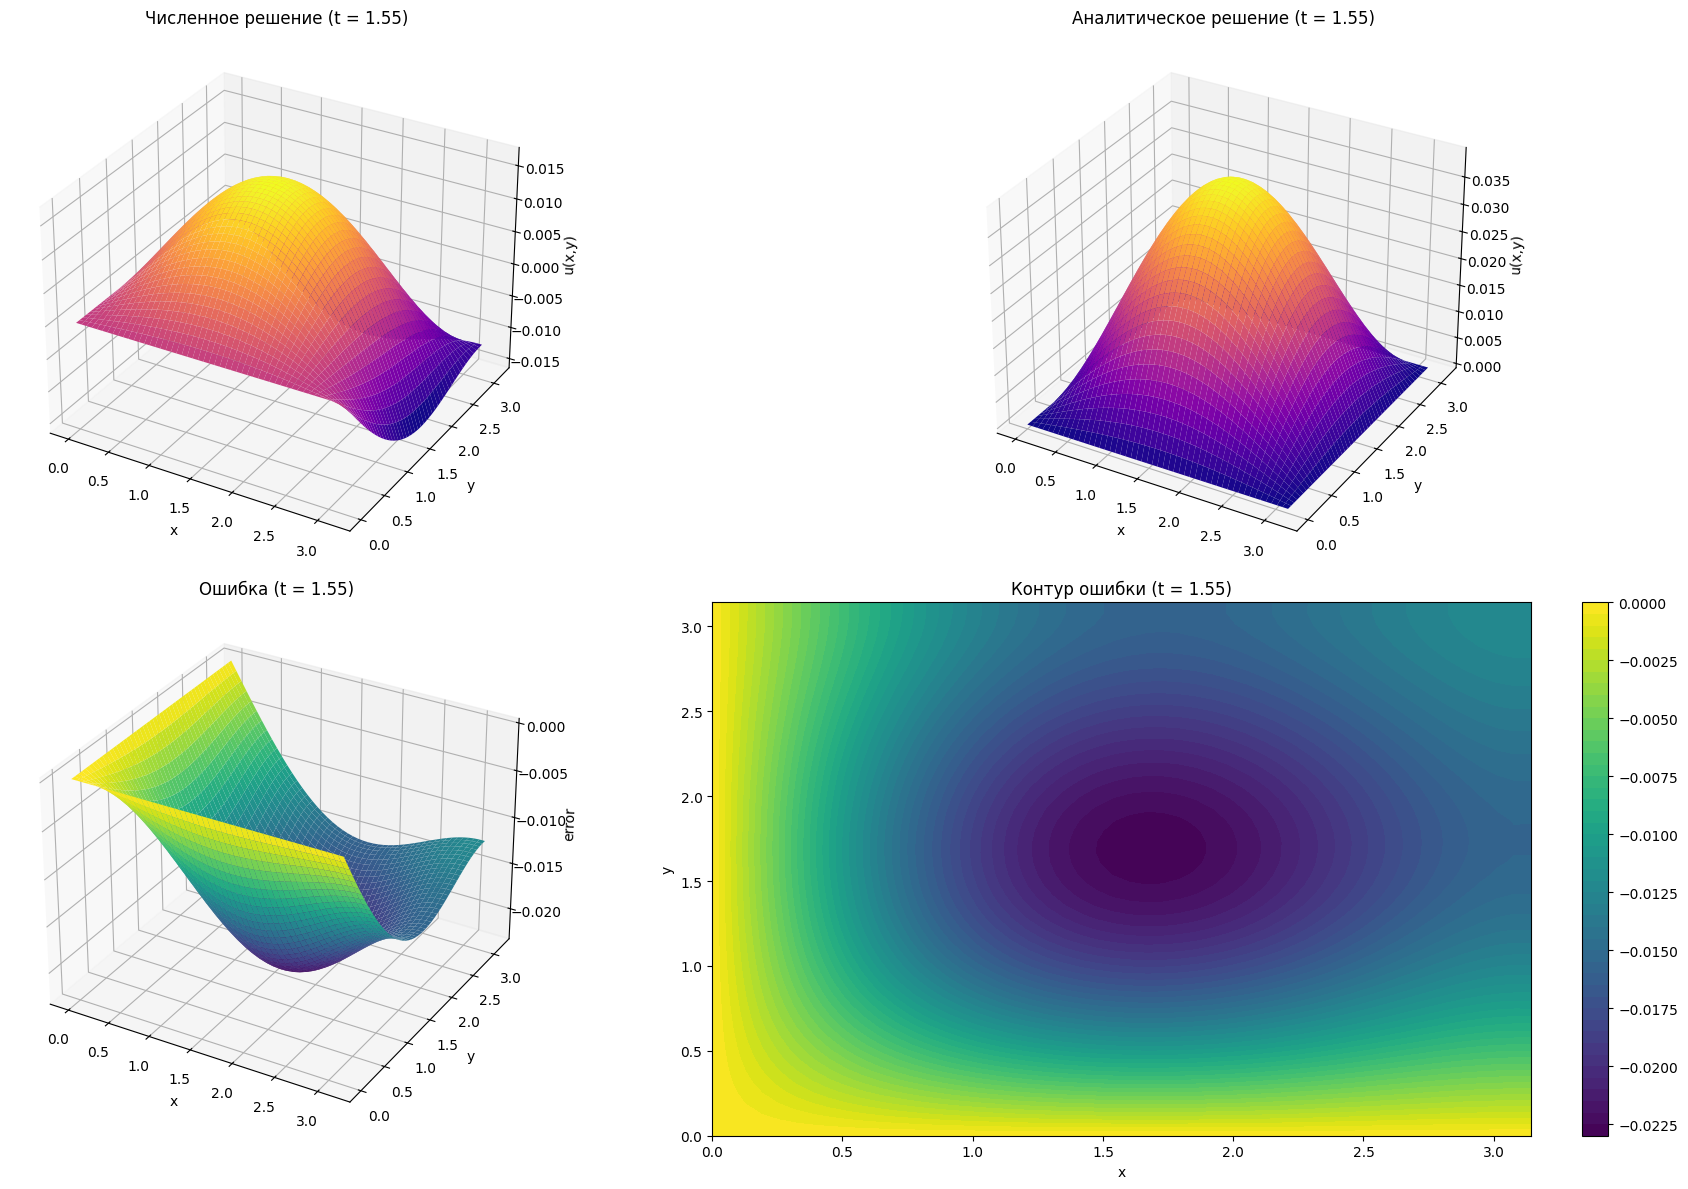

Максимальная ошибка в момент t = 1.55: 0.022889


In [108]:
# Выберите момент времени для отображения (например, последний временной шаг)
k_display = K - K // 4  # Можно выбрать любой другой момент времени: 0, K//2, и т.д.

fig = plt.figure(figsize=(20, 12))

# Численное решение в выбранный момент времени
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
x_plt, y_plt = np.meshgrid(x, y)

# Извлекаем данные для выбранного момента времени
# res имеет форму (n, m, K), поэтому берем срез по последней оси
numerical_solution = res[:, :, k_display]

ax1.plot_surface(x_plt, y_plt, numerical_solution.T, cmap='plasma')
ax1.set_title(f'Численное решение (t = {t[k_display]:.2f})')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('u(x,y)')

# Аналитическое решение в тот же момент времени
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
analytical_solution = np.ndarray((n, m))

for i in range(n):
    for j in range(m):
        analytical_solution[i][j] = analytical(x[i], y[j], t[k_display])

ax2.plot_surface(x_plt, y_plt, analytical_solution.T, cmap='plasma')
ax2.set_title(f'Аналитическое решение (t = {t[k_display]:.2f})')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('u(x,y)')

# Разность между решениями
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
error = numerical_solution - analytical_solution
ax3.plot_surface(x_plt, y_plt, error.T, cmap='viridis')
ax3.set_title(f'Ошибка (t = {t[k_display]:.2f})')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('error')

# Контурный график ошибки
ax4 = fig.add_subplot(2, 2, 4)
contour = ax4.contourf(x_plt, y_plt, error.T, levels=50, cmap='viridis')
plt.colorbar(contour, ax=ax4)
ax4.set_title(f'Контур ошибки (t = {t[k_display]:.2f})')
ax4.set_xlabel('x')
ax4.set_ylabel('y')

plt.tight_layout()
plt.show()

# Вывод максимальной ошибки
print(f"Максимальная ошибка в момент t = {t[k_display]:.2f}: {np.max(np.abs(error)):.6f}")